# Project summary

To be filled out later

# Data import and cleaning

## Importing libraries and seperating DataFrames

We begin be importing the libraries.

In [1]:
#Importing external libraries
import math
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import statsmodels.api as sm
from statsmodels.formula.api import ols

#Importing classes and functions from external files:
from model_classes import ModelSwitcher, DataPreprocessor
from cleaning_functions import *
from feature_engineering import *
from visualization_functions import *

#Configuring options
%matplotlib inline
pd.set_option('display.max_columns', 50)

/home/corey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_outcomes = pd.read_csv("DATASETS/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv")
test_set = pd.read_csv("DATASETS/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv")
df = pd.read_csv("DATASETS/4910797b-ee55-40a7-8668-10efd5c1b960.csv")
target_col = "status_group"

Merging the test set with the set for evaluation before data cleaning optimizes the process by having the full scope of the values from the start.

In [3]:
df_c = pd.concat([df,test_set], axis=0).copy()

Created a seperate dataframe for EDA which combines the training set and their respective values.

In [4]:
df_j = pd.merge(df, df_outcomes, how="left", on="id")

In [5]:
def dummy_creation():
    pass


    
def main_data_cleaning(df):
    df = df.drop(columns=["recorded_by"])
    df = simp_datetime_map(df, "date_recorded")

    return df

## Dealing with missing data

I stored parameters for the imputer functions to process all all of the missing data within OrderedDicts which will be fitted/transformed in bulk through the use of loops. The functtions also create a dummy variable for each indicating that the data was from a missing source within this process to preserve as much information as possible.

The rationale for including some of the entries in the dictionary are explained in the further sections.

In [6]:
impute_dict = OrderedDict([("construction_year",[0, "median", None]),
                          ("population",[0, "median", None]),
                           ("amount_tsh",[0, "constant", .01]),
                            ("subvillage",[np.nan, "constant", "Unknown"]),
                            ("public_meeting",[np.nan, "most_frequent", None]),
                           ("scheme_name",[np.nan, "constant", "Unknown"]),
                           ("permit",[np.nan, "most_frequent", None]),
                          ])

impute_cat_dict = {"funder":["0", "Unknown"],
                   "installer":["0", "Unknown"],
                   "scheme_management":["None", "Unknown"],
                  }

In [7]:
imputes = get_imputer_objs(df_j, impute_dict)

In [8]:
df_c = impute_vals(df_c, impute_dict, imputes)
df_j = impute_vals(df_j, impute_dict, imputes)

df_c=impute_mult_categorical(df_c, impute_cat_dict)
df_j=impute_mult_categorical(df_j, impute_cat_dict)

In [9]:
df_c = main_data_cleaning(df_c)
df_j = main_data_cleaning(df_j)

In [16]:
df_c

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,missing_construction_year,missing_population,missing_public_meeting
0,69572,6000.00,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109.0,True,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0,0,0
1,8776,0.01,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280.0,True,Other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0,0,0
2,34310,25.00,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250.0,True,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,0,0,0
3,67743,0.01,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58.0,True,VWC,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0,0,0
4,19728,0.01,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,150.0,True,NaN,NaN,True,2000.0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.01,2011-02-24,Danida,34,Da,38.852669,-6.582841,Kwambwezi,0,Wami / Ruvu,Yombo,Pwani,6,1,Bagamoyo,Yombo,20.0,True,VWC,Bagamoyo wate,True,1988.0,mono,mono,motorpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,0,0,0
14846,18990,1000.00,2011-03-21,Hiap,0,HIAP,37.451633,-5.350428,Bonde La Mkondoa,0,Pangani,Mkondoa,Tanga,4,7,Kilindi,Mvungwe,2960.0,True,VWC,NaN,False,1994.0,nira/tanira,nira/tanira,handpump,vwc,user-group,pay annually,annually,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,0,0,0
14847,28749,0.01,2013-03-04,Unknown,1476,Unknown,34.739804,-4.585587,Bwawani,0,Internal,Juhudi,Singida,13,2,Singida Rural,Ughandi,200.0,True,VWC,NaN,NaN,2010.0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,dam,dam,surface,communal standpipe,communal standpipe,0,0,0
14848,33492,0.01,2013-02-18,Germany,998,DWE,35.432732,-10.584159,Kwa John,0,Lake Nyasa,Namakinga B,Ruvuma,10,2,Songea Rural,Maposeni,150.0,True,VWC,Mradi wa maji wa maposeni,True,2009.0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,0,0,0


In [30]:
# df_c.info()
full_value_counts(df_c, "waterpoint_type_group")


There are 6 unique values with 0 nan values making up 0.0%
43239-communal standpipe
21884-hand pump
8010-other
959-improved spring
150-cattle trough
8-dam


In [8]:
df_j["region_code"].unique()

array([11, 20, 21, 90, 18,  4, 17, 14, 60, 10,  3, 15, 19, 16, 80,  1,  6,
        2, 12, 13,  5,  7, 99, 24,  9,  8, 40])

In [10]:
for i in df_c["region_code"].unique():
    print(i, df_c[df_c["region_code"] == i]["region"].unique())
# df["region"].unique().shape
# df["region_code"].unique().shape


11 ['Iringa' 'Shinyanga']
20 ['Mara']
21 ['Manyara']
90 ['Mtwara']
18 ['Kagera' 'Lindi']
4 ['Tanga']
17 ['Shinyanga' 'Mwanza']
14 ['Tabora' 'Shinyanga']
60 ['Pwani']
10 ['Ruvuma']
3 ['Kilimanjaro']
15 ['Rukwa']
19 ['Mwanza']
16 ['Kigoma']
80 ['Lindi']
1 ['Dodoma']
6 ['Pwani']
2 ['Arusha']
12 ['Mbeya' 'Mwanza']
13 ['Singida']
5 ['Morogoro' 'Tanga']
7 ['Dar es Salaam']
99 ['Mtwara']
24 ['Arusha']
9 ['Mtwara']
8 ['Lindi']
40 ['Pwani']


In [9]:


# df_c["construction_year"].ravel()

In [41]:
df_j[target_col].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [ ]:
df["amount_tsh"].unique()

In [ ]:
df.info()

# EDA

## The continuous variables

### Evaluating total standing head

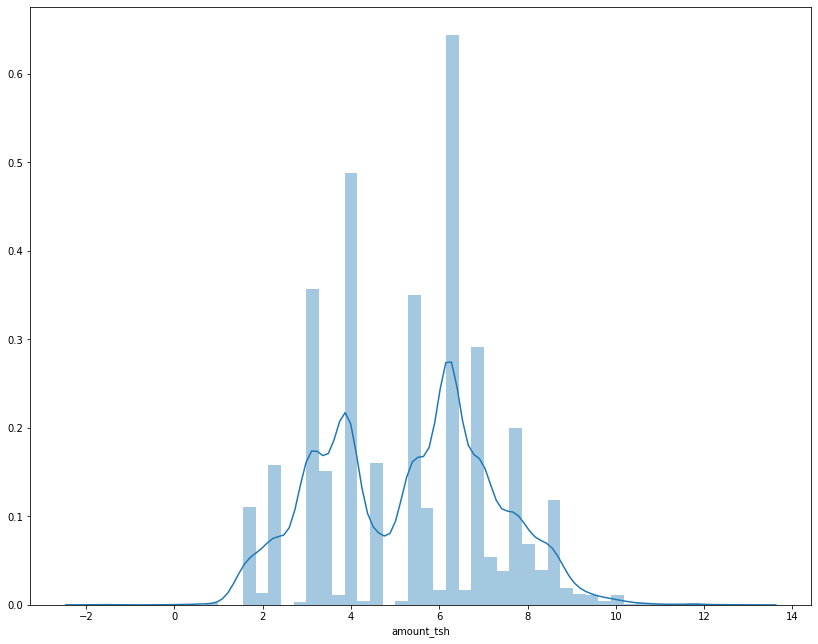

In [27]:
f, ax = plt.subplots(figsize=(14, 11))
non_zero_tsh = df_j[df_j["amount_tsh"]!= 0]["amount_tsh"]
logged_tsh = non_zero_tsh.map(lambda x: 0 if x<= 0 else math.log(x))
sns.distplot(logged_tsh)


After zero, the smallest measured value of total standing head is .2. For the purpose of not breaking the log transformation and maintaining the negative scale, I have imputed values that are based off of that minimum but reduced by a factor of 20 to keep maintain that relationship while capturing the fact that it was measured at zero in a dummy variable.

### Evaluating any affect of population size

I began by exploring the relationship between the size of the population and the condition of the well.

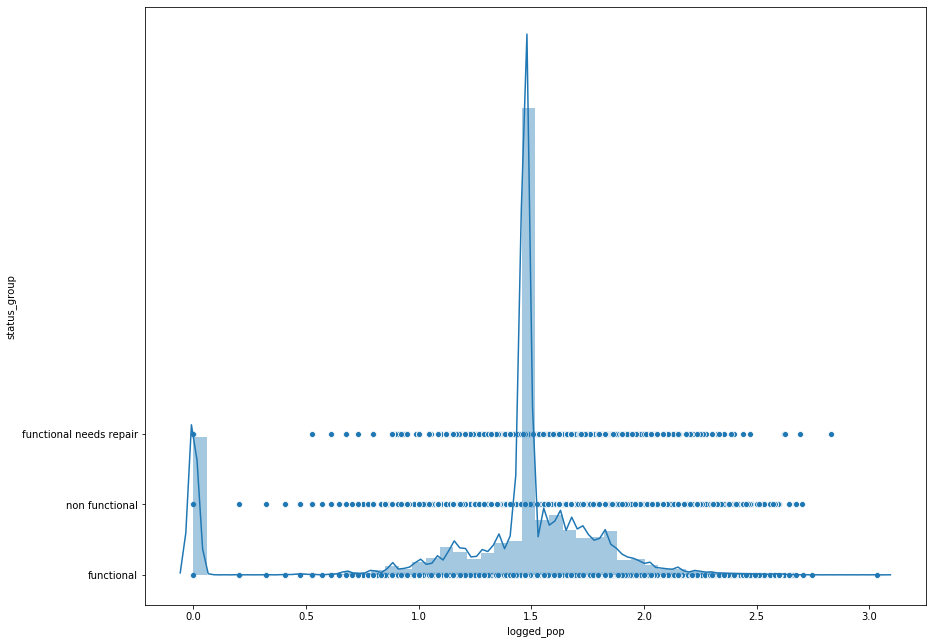

In [15]:
df_j["logged_pop"] = df_j["population"].map(lambda x: 0 if x<= 0 else math.log(x, 30))
f, ax = plt.subplots(figsize=(14, 11))
sns.distplot(df_j["logged_pop"])
sns.scatterplot(x="logged_pop", y=target_col, data=df_j)

It appears that the population values can be subset into two distinct groups. Half of which are registered with no population, while the other half follow an approximate normal distribute when a heavy log transformation is applied,

In [69]:
df_non_zero_pop = df_j[df_j["logged_pop"] != 0]
df_non_zero_pop[["logged_pop", target_col]].groupby(target_col).mean()

,logged_pop
status_group,
functional,1.507603
functional needs repair,1.583825
non functional,1.584797


In [77]:
#ANOVA test comparing the logged population size between the outcomes
formula = 'logged_pop ~ C(status_group)'
lm = ols(formula, df_non_zero_pop).fit()
table = sm.stats.anova_lm(lm, typ=2)
print("ANOVA for all outcomes")
print(table)

ANOVA for all outcomes
                      sum_sq       df           F        PR(>F)
C(status_group)    44.706518      2.0  217.096115  2.348120e-94
Residual         3190.982254  30991.0         NaN           NaN


A P value that small was likely a result between the difference in population between the whether a well currently worked or not(distinctions between how they weren't working was much less). A non linear relationship prevents it from being useful in any logistic regression, however it is interesting to note the relationship.

Perhaps there is a small sampling bias that is introduced where larger populations bring non functional wells to attention more or heavier use is affecting the degradation.

In [106]:
#Grabs the respective counts of well functionality in the provided data.
totals = df_j[["logged_pop", target_col]].groupby(target_col).count()["logged_pop"]

#Dataframe only the wells that have zeros input for population.
df_zero_pop = df_j[df_j["logged_pop"] == 0]

#Returns proportions for missing population data depending on the status of the well.
print(totals.index)
df_zero_pop[["logged_pop", target_col]].groupby(target_col).count()["logged_pop"]/totals.values

Index(['functional', 'functional needs repair', 'non functional'], dtype='object', name='status_group')


status_group
functional                 0.439722
functional needs repair    0.493167
non functional             0.529793
Name: logged_pop, dtype: float64

The proportions of zeros in population data vary among the different outcomes in the sample. In order to preserve that information, when imputing median, I will create a dummy variable that indicates a zero value while preserving the rest of the continuous entries. While the histogram indicates that there remains a disproportionatly large block of nonzero population sizes at very small values, doing the same process to would likely negatively impact the model.

## Putting them together

### TSH VS Years old

In [14]:
df_j["logged_tsh"] = df_j["amount_tsh"].map(lambda x: math.log(x))

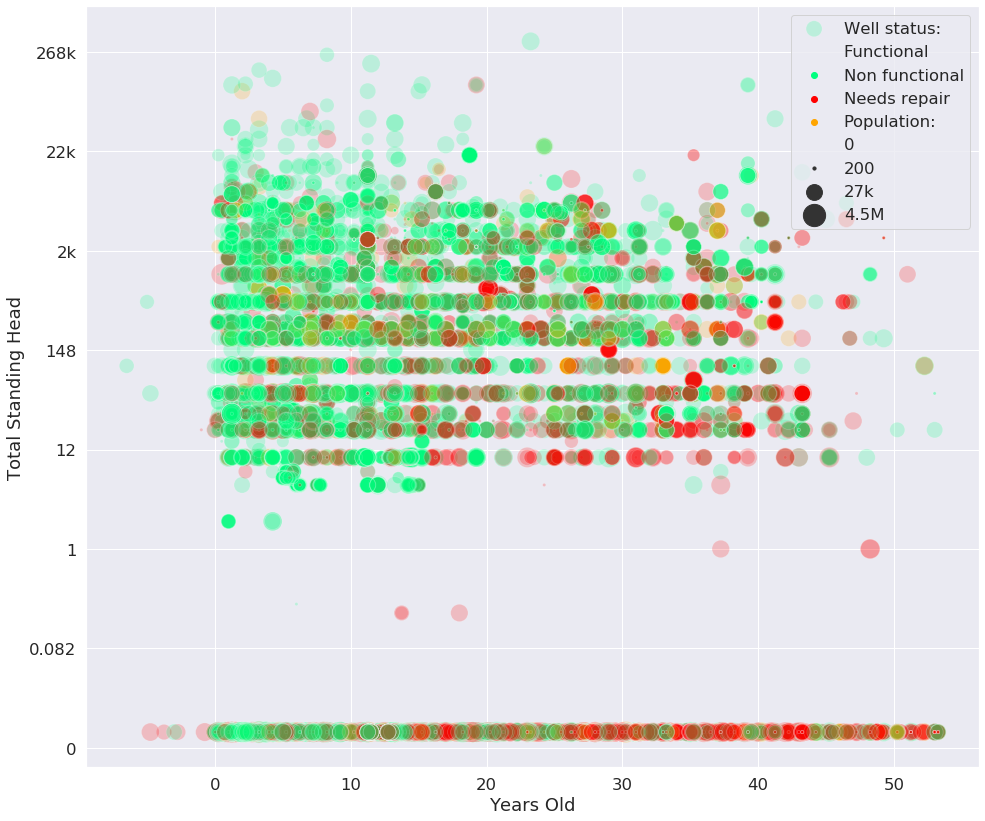

In [106]:
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
f, ax = plt.subplots(figsize=(16, 14))
functional_pal = {"functional":"springgreen", "functional needs repair":"orange", "non functional":"red"}
sns.scatterplot(x="years_old", y="logged_tsh", hue=target_col,
                    size="logged_pop", sizes=(10, 500), alpha=.2, palette=functional_pal,
                    data = df_j)
lgnd = ["Well status:", "Functional", "Non functional", "Needs repair",
       "Population:", "0", "200", "27k", "4.5M"]
ax.legend(lgnd)
ax.set_ylabel('Total Standing Head')
ax.set_xlabel('Years Old')
ticks = list(np.arange(-5,15,2.5))
tick_labels = unlog_plot(ticks, math.e)
tick_labels.insert(1, "0")
ax.set(yticklabels=tick_labels)
plt.show()

-6.5

### Correlation heatmap

<Figure size 1080x720 with 0 Axes>

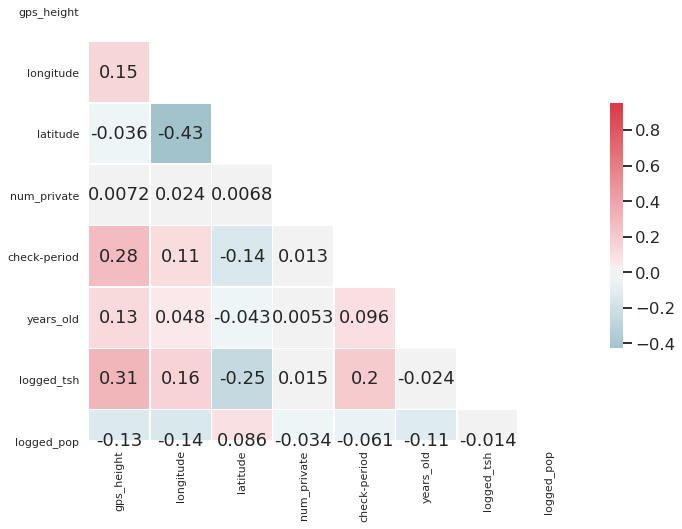

In [137]:
cont_features = ["gps_height", "longitude", "latitude",
                "num_private", "check-period", "years_old",
               "logged_tsh", "logged_pop"]

trimmed_heatmap(df_c, cont_features)

### scratch

In [103]:
math.log(df_j["amount_tsh"].max())

12.765688433465597

In [ ]:
cat_cols = ["quality_group"]
df_j.quality_group.unique()
sns.distplot(target_col, labels=cat_cols)

In [ ]:
data = DataPreprocessor(df_j, target_col, cont_features=cont_features, scale_type="minmax", poly_degree=2)

In [ ]:
model = ModelSwitcher(data, duplicate=True)

In [ ]:
model.data.poly_degree = 1
model.data._poly_features()
model.data.X

# Feature Engineering/Selection

In [10]:
# df_j["month_checked"] = df_j["date_recorded"].map(lambda x: x.month)
df_j = add_features(df_j)

# month_totals = totals = df_j[["logged_pop", target_col]].groupby(target_col).count()["logged_pop"]
df_j

# sns_scatterplot
# df_j.groupby("month_checked").count()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,missing_construction_year,missing_population,missing_public_meeting,missing_permit,check-season,check-period,years_old
0,69572,6000.00,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109.0,True,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,0,0,0,0,summer,0.309017,12.25
1,8776,0.01,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280.0,True,Other,Unknown,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,0,0,0,0,summer,0.436651,3.25
2,34310,25.00,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250.0,True,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,0,0,0,0,summer,0.570242,4.25
3,67743,0.01,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58.0,True,VWC,Unknown,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,0,0,0,0,summer,0.886071,27.00
4,19728,0.01,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,150.0,True,Unknown,Unknown,True,2000.0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,1,1,0,0,winter,-0.980469,11.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.00,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125.0,True,Water Board,Losaa Kia water supply,True,1999.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,0,0,0,0,fall,-0.519744,14.25
59396,27263,4700.00,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56.0,True,VWC,Ikondo electrical water sch,True,1996.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional,0,0,0,0,fall,-0.577292,15.25
59397,37057,0.01,2011-04-11,Unknown,0,Unknown,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,150.0,True,VWC,Unknown,False,2000.0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional,1,1,0,0,fall,-0.167052,11.25
59398,31282,0.01,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,150.0,True,VWC,Unknown,True,2000.0,nira/tanira,nira/tanira,handpump,vwc,

In [14]:
df_j[[target_col, "years_old"]].groupby(target_col).mean()

,years_old
status_group,
functional,12.253859
functional needs repair,15.125724
non functional,17.069718


In [32]:
print(df_j["seasonal_period"].max())
df_j[[target_col, "seasonal_period"]].groupby(target_col).mean()

0.9998518392091162


,seasonal_period
status_group,
functional,0.191443
functional needs repair,0.223154
non functional,0.204427


# Missing longitude and latitude

In [131]:
df_j[df_j["longitude"]==0]
df_j[(df_j["region"]=="Shinyanga")&(df_j["gps_height"]>0)]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,missing_construction_year,missing_population,check-season,check-period,years_old,logged_tsh,logged_pop
383,16341,0.01,2012-10-21,Wvt,1362,WVT,34.217656,-2.974327,Mtakuja,0,Lake Victoria,Mtakuja,Shinyanga,17,1,Bariadi,Mhunze,450.0,True,GeoData Consultants Ltd,WUG,NaN,False,2008.0,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,0,0,spring,0.357698,4.75,-4.605170,1.796205
764,53188,0.01,2013-02-14,Dwsp,1356,DWE,34.144579,-2.956513,Gasela,0,Lake Victoria,Matare,Shinyanga,17,1,Bariadi,Lagangabilili,500.0,True,GeoData Consultants Ltd,WUG,NaN,False,1996.0,swn 80,swn 80,handpump,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair,0,0,summer,0.714673,17.00,-4.605170,1.827182
795,59179,1000.00,2012-10-21,Lwi,1328,LWI,34.175690,-2.972687,Upendo,0,Lake Victoria,Kiluluma,Shinyanga,17,1,Bariadi,Mhunze,300.0,True,GeoData Consultants Ltd,WUG,NaN,False,2005.0,india mark ii,india mark ii,handpump,wug,user-group,pay when scheme fails,on failure,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional,0,0,spring,0.357698,7.75,6.907755,1.676992
1291,25248,0.01,2013-01-31,Dwsp,1340,DWE,34.042961,-2.954429,Mwamabondo,0,Lake Victoria,Musoma,Shinyanga,17,1,Bariadi,Nkoma,250.0,False,GeoData Consultants Ltd,WUG,NaN,False,1998.0,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair,0,0,summer,0.860961,15.00,-4.605170,1.623387
1666,18326,0.01,2013-02-14,Dwsp,1354,DWE,34.176786,-2.928304,Tumaini,0,Lake Victoria,Ndolelezi,Shinyanga,17,1,Bariadi,Lagangabilili,500.0,True,GeoData Consultants Ltd,WUG,NaN,False,1997.0,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair,0,0,summer,0.714673,16.00,-4.605170,1.827182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58303,43154,0.01,2012-10-22,Rwssp,1378,DWE,34.235404,-2.966587,Maelewano,0,Lake Victoria,Matumbi,Shinyanga,17,1,Bariadi,Mhunze,500.0,True,GeoData Consultants Ltd,WUG,NaN,False,2005.0,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair,0,0,spring,0.373720,7.75,-4.605170,1.827182
58464,73405,0.01,2013-02-02,Dwsp,1311,DWE,34.001878,-3.016739,Njiapanda,0,Lake Victoria,Mwambaga Magharibi,Shinyanga,17,1,Bariadi,Nkoma,1.0,False,GeoData Consultants Ltd,WUG,NaN,False,1999.0,other,other,other,wug,user-group,never pay,never pay,unknown,unknown,dry,dry,other,other,unknown,other,other,non functional,0,0,summer,0.842942,14.00,-4.605170,0.000000
58762,57385,0.01,2012-10-21,Wvt,1359,WVT,34.232772,-2.936518,Twende Na Wakati,0,Lake Victoria,Mwakiliyoma,Shinyanga,17,1,Bariadi,Mhunze,360.0,True,GeoData Consultants Ltd,WUG,NaN,False,2007.0,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,0,0,spring,0.357698,5.75,-4.605170,1.730598
58789,13602,500.00,2013-01-31,Wv

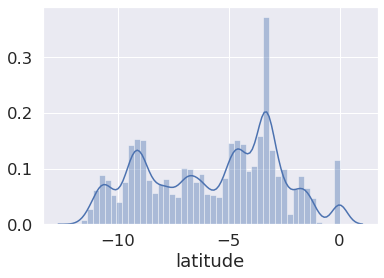

In [124]:
sns.distplot(df_j["latitude"])

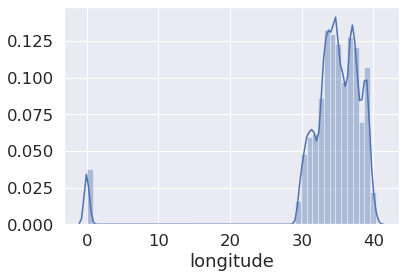

In [123]:
sns.distplot(df_j["longitude"])

# Dealing with missing GPS height

In [114]:
df_j[(df_j["gps_height"]>0) & (df_j["gps_height"]<10)]
df_j["gps_height"].mean()

668.297239057239

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,missing_construction_year,missing_population,check-season,check-period,years_old,logged_tsh,logged_pop
34,41583,0.01,2011-02-23,NaN,-41,NaN,39.812912,-7.889986,Msikitini Wa Ijumaa,0,Rufiji,Kilombero B,Pwani,60,63,Mafia,Baleni,100.0,True,GeoData Consultants Ltd,VWC,NaN,False,2000.0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,1,0,summer,0.598181,11.25,-4.60517,1.353985
39790,66420,0.01,2011-02-23,NaN,-43,NaN,39.819169,-7.890459,Kanisani,0,Rufiji,Kilombero A,Pwani,60,63,Mafia,Baleni,100.0,True,GeoData Consultants Ltd,VWC,NaN,False,2000.0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair,1,0,summer,0.598181,11.25,-4.60517,1.353985


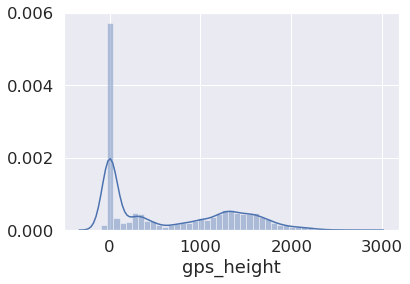

In [121]:
sns.distplot(df_j["gps_height"])
df_j[(df_j["gps_height"]<0)]
df_j[(df_j["longitude"]>39.812912) & (df_j["longitude"]<40.112912)& (df_j["latitude"]<-7.889986)& (df_j["latitude"]>-8.133632)]

# Missing num private

476      5
608      3
818      5
952      5
1197     5
        ..
14035    5
14194    1
14514    1
14639    2
14645    2
Name: num_private, Length: 253, dtype: int64

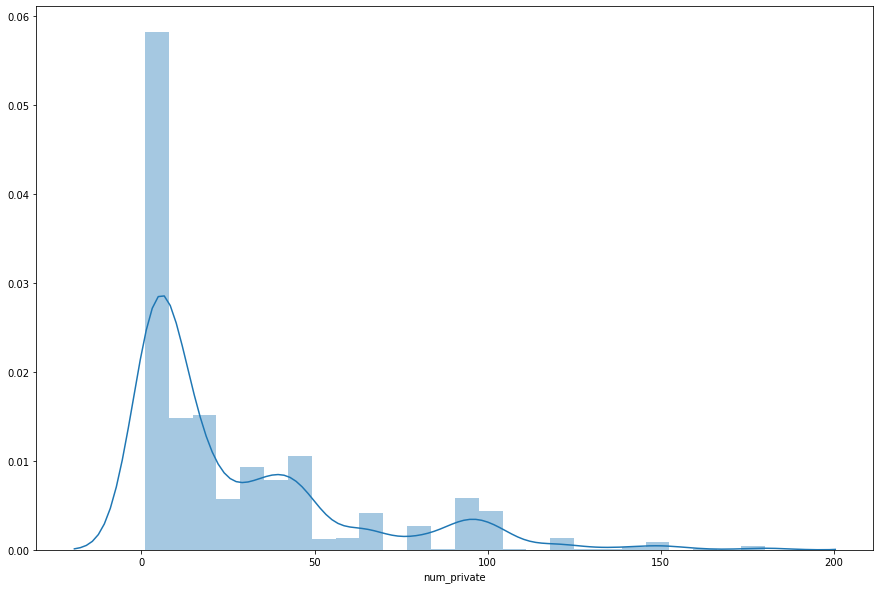

In [39]:
# sns.distplot()
plt.figure(figsize=(15, 10))
sns.distplot(df_c[(df_c["num_private"] !=0)&(df_c["num_private"] <=200)]["num_private"])
df_c[(df_c["num_private"] !=0)&(df_c["num_private"] <=5)]["num_private"]

# The model

In [1]:
#Importing external libraries
import math
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import statsmodels.api as sm
from statsmodels.formula.api import ols

#Importing classes and functions from external files:
from model_classes import ModelSwitcher, DataPreprocessor
from cleaning_functions import *
from feature_engineering import *
from visualization_functions import *

#Configuring options
%matplotlib inline
pd.set_option('display.max_columns', 50)
df1 = pd.read_pickle("basic_cleaned")

/home/corey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
target_col = "status_group"
categorical = {
    "nominal_features":["funder", "installer", "wpt_name", "basin", "subvillage",
                    "region", "region_code", "lga", "ward", "public_meeting",
                   "scheme_management", "scheme_name", "permit",
                   "extraction_type", "extraction_type_group", "extraction_type_class",
                    "management", "management_group", "payment", "payment_type",
                    "water_quality", "quality_group", "source", "source_type", "source_class",
                    "waterpoint_type", "waterpoint_type_group"
                   ],
    "impute_dummies":extract_column_names(df1, "^missing_")
}
continuous = {"untransformed":["gps_height", "longitude", "latitude", "num_private",
                               "check-period", "years_old"],
             "transformed": {"logged": {"population":30, "amount_tsh":None}
             }}

In [5]:
#  categorical,
data = DataPreprocessor(df1, target_col, categorical, continuous, True, True)
data.data_preprocessing(balance_class="upsample", scale_type="minmax", poly_degree=2)
data.X_train

Getting polynomial features of degree 2
Performing upsample
Using Min/Max scaler


,gps_height,longitude,latitude,num_private,check-period,years_old,population_log_b30,amount_tsh_ln,funder,installer,wpt_name,basin,subvillage,region,region_code,lga,ward,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,...,years_old missing_construction_year,years_old missing_population,years_old missing_public_meeting,years_old missing_permit,population_log_b30^2,population_log_b30 amount_tsh_ln,population_log_b30 missing_construction_year,population_log_b30 missing_population,population_log_b30 missing_public_meeting,population_log_b30 missing_permit,amount_tsh_ln^2,amount_tsh_ln missing_construction_year,amount_tsh_ln missing_population,amount_tsh_ln missing_public_meeting,amount_tsh_ln missing_permit,missing_construction_year^2,missing_construction_year missing_population,missing_construction_year missing_public_meeting,missing_construction_year missing_permit,missing_population^2,missing_population missing_public_meeting,missing_population missing_permit,missing_public_meeting^2,missing_public_meeting missing_permit,missing_permit^2
1159,0.033113,0.793776,0.712740,0.000000,0.734164,0.322176,0.485269,0.000000,World Vision,World vision,Busabaga B,Lake Tanganyika,Busabaga,Shinyanga,17,Bukombe,Ilolangulu,False,WUG,Unknown,True,nira/tanira,nira/tanira,handpump,wug,...,12.75,12.75,0.0,0.0,2.170311,-6.784325,1.473197,1.473197,0.0,0.0,21.207592,-4.60517,-4.60517,-0.0,-0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
26556,0.668874,0.859620,0.217848,0.000000,0.055005,0.669456,0.444044,0.622870,Unicef,DWE,Kwa Ngavatula,Rufiji,Isupilo,Iringa,11,Njombe,Mdandu,True,WUA,wanging'ombe water supply s,True,gravity,gravity,gravity,wua,...,0.00,0.00,0.0,0.0,1.817226,8.377572,0.000000,0.000000,0.0,0.0,38.621354,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50388,0.041575,0.963831,0.518136,0.029244,0.679296,0.715481,0.634458,0.000000,Private Individual,Amboni Plantation,Kwa Welfare,Pangani,Estate,Tanga,4,Pangani,Kipumbwi,True,Private operator,Koronani Borehole,False,submersible,submersible,submersible,private operator,...,0.00,0.00,0.0,0.0,3.709900,-8.870064,0.000000,0.000000,0.0,0.0,21.207592,-0.00000,-0.00000,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12301,0.052612,0.968854,0.401307,0.000000,0.638467,0.163180,0.446001,0.530218,Unknown,Unknown,Kwa Mubanga,Wami / Ruvu,Mtaa Wa Nyeburu,Dar es Salaam,7,Ilala,Chanika,True,Private operator,Unknown,False,submersible,submersible,submersible,private operator,...,0.00,0.00,0.0,0.0,1.833275,6.235331,0.000000,0.000000,0.0,0.0,21.207592,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42506,0.537528,0.866126,0.153421,0.000000,0.654939,0.313808,0.389846,0.765920,Roman,Roman,none,Lake Nyasa,Irongi,Iringa,11,Ludewa,Mundindi,True,VWC,Roman,False,gravity,gravity,gravity,vwc,...,0.00,0.00,0.0,0.0,1.400696,10.295964,0.000000,0.000000,0.0,0.0,75.681557,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45933,0.033113,0.831803,0.256636,0.000000,0.519699,0.297071,0.485269,0.000000,Danida,Government,Richard Mwaigomole,Lake Rukwa,Chalangwa C,Mbeya,12,Chunya,Chalangwa,True,VWC,Unknown,True,gravity,gravity,gravity,vwc,...,11.25,11.25,0.0,0.0,2.170311,-6.784325,1.473197,1.473197,0.0,0.0,21.207592,-4.60517,-4.60517,-0.0,-0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
38726,0.593451,0.881934,0.630498,0.000000,0.839364,0.129707,0.580260,0.000000,Government Of Tanzania,DWE,Qorias,Internal,Qorias,Manyara,21,Babati,Duru,True,VWC,Unknown,True,swn 80,swn 80,handpump,vwc,...,0.00,0.00,0.0,0.0,3.103147,-8.112353,0.000000,0.000000,0.0,0.0,21.207592,-0.00000,-0.00000,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57393,0.033113,0.789332,0.910557,0.000000,0.040366,0.301255,0.485269,0.000000,World Vision,DWE,

In [6]:
df1[target_col].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [9]:
data.df[target_col].unique()[

'functional'

In [12]:
test = {"r":5, "w":17, "x": 27}
max(test, key=test.get)

'x'

In [4]:
data.cols_logged

Index(['population_log_b30', 'amount_tsh_ln'], dtype='object')